 ### Step 1: Import Required Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning (optional)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# Save/load models
import joblib

# Warnings off (optional)
import warnings
warnings.filterwarnings('ignore')


### Step 2: Load Dataset

In [4]:
# Load Excel file
df = pd.read_excel('POWER_Point_Hourly_20230101_20240101_022d03N_077d69E_LST.xlsx')

# Check shape & columns
print(df.shape)
print(df.columns)


(8798, 10)
Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')


In [3]:
# checking the info in excel for any NaN  values(empty rows and columns)
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Example if your header starts at row 15:
df = pd.read_excel('POWER_Point_Hourly_20230101_20240101_022d03N_077d69E_LST.xlsx', header=14)  


In [6]:
from IPython.display import display

try:
    df = pd.read_excel('POWER_Point_Hourly_20230101_20240101_022d03N_077d69E_LST.xlsx', header=14)
    display(df.head())
except Exception as e:
    print(f"Error loading file: {e}")


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_KT,T2M,RH2M,PS
0,2023,1,1,0,0.0,0.0,-999.0,13.01,74.64,95.76
1,2023,1,1,1,0.0,0.0,-999.0,12.41,77.93,95.74
2,2023,1,1,2,0.0,0.0,-999.0,11.89,80.85,95.72
3,2023,1,1,3,0.0,0.0,-999.0,11.42,83.52,95.73
4,2023,1,1,4,0.0,0.0,-999.0,11.00,86.04,95.77


### 📊 dataset Columns

- **YEAR** → Year of measurement  
- **MO** → Month (1-12)  
- **DY** → Day of the month (1-31)  
- **HR** → Hour of the day (0-23)  
- **ALLSKY_SFC_SW_DWN** → Solar radiation on the surface (all sky conditions)  
- **CLRSKY_SFC_SW_DWN** → Solar radiation on the surface (clear sky only)  
- **ALLSKY_KT** → Clearness index (0-1)  
- **T2M** → Air temperature at 2 meters (°C)  
- **RH2M** → Relative humidity at 2 meters (%)  
- **PS** → Surface pressure (hPa)


### Step 3: Data Preprocessing

In [7]:
#Inspect for missing or bad data:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YEAR               8784 non-null   int64  
 1   MO                 8784 non-null   int64  
 2   DY                 8784 non-null   int64  
 3   HR                 8784 non-null   int64  
 4   ALLSKY_SFC_SW_DWN  8784 non-null   float64
 5   CLRSKY_SFC_SW_DWN  8784 non-null   float64
 6   ALLSKY_KT          8784 non-null   float64
 7   T2M                8784 non-null   float64
 8   RH2M               8784 non-null   float64
 9   PS                 8784 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 686.4 KB


YEAR                 0
MO                   0
DY                   0
HR                   0
ALLSKY_SFC_SW_DWN    0
CLRSKY_SFC_SW_DWN    0
ALLSKY_KT            0
T2M                  0
RH2M                 0
PS                   0
dtype: int64

In [8]:
# Quick look
df.head()


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_KT,T2M,RH2M,PS
0,2023,1,1,0,0.0,0.0,-999.0,13.01,74.64,95.76
1,2023,1,1,1,0.0,0.0,-999.0,12.41,77.93,95.74
2,2023,1,1,2,0.0,0.0,-999.0,11.89,80.85,95.72
3,2023,1,1,3,0.0,0.0,-999.0,11.42,83.52,95.73
4,2023,1,1,4,0.0,0.0,-999.0,11.00,86.04,95.77


In [9]:
#Drop or fill NaNs:
df = df.dropna()  # or use df.fillna(method='ffill')


#### Create lag features (Random Forest):

In [10]:
# If you filtered df earlier, make a copy
df = df.copy()

# Use .loc to set new columns
df.loc[:, 'ALLSKY_SFC_SW_DWN_lag1'] = df['ALLSKY_SFC_SW_DWN'].shift(1)
df.loc[:, 'ALLSKY_SFC_SW_DWN_lag2'] = df['ALLSKY_SFC_SW_DWN'].shift(2)

df = df.dropna()

df.head()


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_KT,T2M,RH2M,PS,ALLSKY_SFC_SW_DWN_lag1,ALLSKY_SFC_SW_DWN_lag2
2,2023,1,1,2,0.00,0.00,-999.00,11.89,80.85,95.72,0.0,0.0
3,2023,1,1,3,0.00,0.00,-999.00,11.42,83.52,95.73,0.0,0.0
4,2023,1,1,4,0.00,0.00,-999.00,11.00,86.04,95.77,0.0,0.0
5,2023,1,1,5,0.00,0.00,-999.00,10.69,87.54,95.84,0.0,0.0
6,2023,1,1,6,6.52,6.75,0.22,10.65,86.41,95.91,0.0,0.0


#### Step 4: Basic Descriptive Stats

In [11]:
# Info summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8782 entries, 2 to 8783
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   YEAR                    8782 non-null   int64  
 1   MO                      8782 non-null   int64  
 2   DY                      8782 non-null   int64  
 3   HR                      8782 non-null   int64  
 4   ALLSKY_SFC_SW_DWN       8782 non-null   float64
 5   CLRSKY_SFC_SW_DWN       8782 non-null   float64
 6   ALLSKY_KT               8782 non-null   float64
 7   T2M                     8782 non-null   float64
 8   RH2M                    8782 non-null   float64
 9   PS                      8782 non-null   float64
 10  ALLSKY_SFC_SW_DWN_lag1  8782 non-null   float64
 11  ALLSKY_SFC_SW_DWN_lag2  8782 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 891.9 KB


In [12]:
# Count columns
print(f"Total columns: {len(df.columns)}")

Total columns: 12


In [13]:
# Print all column names
print("Columns:", df.columns.tolist())

Columns: ['YEAR', 'MO', 'DY', 'HR', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'RH2M', 'PS', 'ALLSKY_SFC_SW_DWN_lag1', 'ALLSKY_SFC_SW_DWN_lag2']


In [14]:
# Count of unique values per column 
print("\nUnique value counts:")
print(df.nunique())


Unique value counts:
YEAR                         2
MO                          12
DY                          31
HR                          24
ALLSKY_SFC_SW_DWN         4220
CLRSKY_SFC_SW_DWN         4252
ALLSKY_KT                   80
T2M                       2644
RH2M                      5396
PS                         235
ALLSKY_SFC_SW_DWN_lag1    4220
ALLSKY_SFC_SW_DWN_lag2    4220
dtype: int64


In [15]:
# Descriptive stats for numeric columns
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
YEAR,8782.0,2023.002733,0.052208,2023.00,2023.0000,2023.000,2023.0000,2024.00
MO,8782.0,6.512184,3.454789,1.00,4.0000,7.000,10.0000,12.00
DY,8782.0,15.683671,8.816488,1.00,8.0000,16.000,23.0000,31.00
HR,8782.0,11.502505,6.921374,0.00,6.0000,12.000,17.7500,23.00
ALLSKY_SFC_SW_DWN,8782.0,205.744431,285.359079,0.00,0.0000,6.750,391.5150,1048.68
CLRSKY_SFC_SW_DWN,8782.0,249.765707,326.264564,0.00,0.0000,8.560,528.1000,1049.20
ALLSKY_KT,8782.0,-478.095112,499.316276,-999.00,-999.0000,0.130,0.5100,0.81
T2M,8782.0,25.021719,6.443423,7.47,21.0825,24.950,28.8475,43.80
RH2M,8782.0,58.197158,28.380996,4.89,31.8625,61.405,84.6675,100.00
PS,8782.0,95.138145,0.477588,93.89,94.7500,95.150,95.5500,96.28


##### Plot target variable distribution

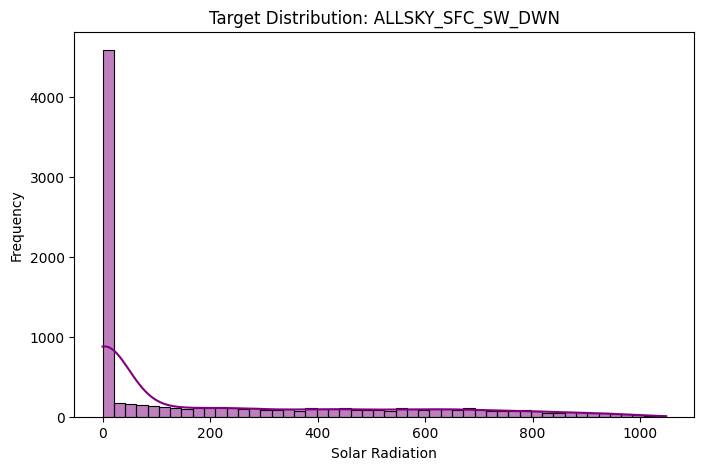

In [16]:
# Plot target variable distribution
plt.figure(figsize=(8,5))
sns.histplot(df['ALLSKY_SFC_SW_DWN'], bins=50, kde=True,color='purple')
plt.title('Target Distribution: ALLSKY_SFC_SW_DWN')
plt.xlabel('Solar Radiation')
plt.ylabel('Frequency')
plt.show()


In [17]:
# Year column’s unique values and counts 
print("=== Column: YEAR ===")
print(f"Unique Count: {df['YEAR'].nunique()}")
print("Value Counts:")
print(df['YEAR'].value_counts(dropna=False))
print("\nUnique Values:")
print(df['YEAR'].unique())


=== Column: YEAR ===
Unique Count: 2
Value Counts:
YEAR
2023    8758
2024      24
Name: count, dtype: int64

Unique Values:
[2023 2024]


In [18]:
# mo column’s unique values and counts 
print("=== Column: MO ===")
print(f"Unique Count: {df['MO'].nunique()}")
print("Value Counts:")
print(df['MO'].value_counts(dropna=False))
print("\nUnique Values:")
print(df['MO'].unique())


=== Column: MO ===
Unique Count: 12
Value Counts:
MO
1     766
3     744
7     744
5     744
12    744
10    744
8     744
4     720
9     720
6     720
11    720
2     672
Name: count, dtype: int64

Unique Values:
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [19]:
#Allsky_sfc column’s unique values and counts
print("=== Column: ALLSKY_SFC_SW_DWN ==")
print(f"Unique Count: {df['ALLSKY_SFC_SW_DWN'].nunique()}")
print("Value Counts:")
print(df['DY'].value_counts(dropna=False))
print("\nUnique Values:")
print(df['ALLSKY_SFC_SW_DWN'].unique())


=== Column: ALLSKY_SFC_SW_DWN ==
Unique Count: 4220
Value Counts:
DY
1     310
2     288
3     288
4     288
5     288
6     288
7     288
8     288
9     288
10    288
11    288
12    288
13    288
14    288
15    288
16    288
17    288
18    288
19    288
20    288
21    288
22    288
23    288
24    288
25    288
26    288
27    288
28    288
29    264
30    264
31    168
Name: count, dtype: int64

Unique Values:
[  0.     6.52 108.51 ... 579.8  501.85 210.5 ]


### Step 7: Correlation Matrix & Heatmap
### Multivariate Anslysis

In [20]:
# Checking correlation between numerical features 
df.select_dtypes(include=np.number).corr()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_KT,T2M,RH2M,PS,ALLSKY_SFC_SW_DWN_lag1,ALLSKY_SFC_SW_DWN_lag2
YEAR,1.000000,-0.083528,-0.087190,-0.000019,-0.010471,-0.015718,-0.006586,-0.042080,0.015338,0.053459,-0.010471,-0.010471
MO,-0.083528,1.000000,0.018488,-0.000578,-0.080281,-0.045366,-0.020643,-0.158791,0.560906,-0.026449,-0.080281,-0.080281
DY,-0.087190,0.018488,1.000000,-0.000603,-0.011331,-0.003156,-0.000582,0.005652,0.054470,-0.032793,-0.011331,-0.011331
HR,-0.000019,-0.000578,-0.000603,1.000000,-0.016607,-0.017741,-0.031317,0.238994,-0.147706,-0.024559,0.087575,0.191757
ALLSKY_SFC_SW_DWN,-0.010471,-0.080281,-0.011331,-0.016607,1.000000,0.944714,0.691299,0.631498,-0.462582,0.046943,0.942680,0.790299
CLRSKY_SFC_SW_DWN,-0.015718,-0.045366,-0.003156,-0.017741,0.944714,1.000000,0.733923,0.621028,-0.360035,-0.062338,0.891684,0.745996
ALLSKY_KT,-0.006586,-0.020643,-0.000582,-0.031317,0.691299,0.733923,1.000000,0.507151,-0.287985,-0.052336,0.681326,0.633203
T2M,-0.042080,-0.158791,0.005652,0.238994,0.631498,0.621028,0.507151,1.000000,-0.478821,-0.445467,0.694449,0.698816
RH2M,0.015338,0.560906,0.054470,-0.147706,-0.462582,-0.360035,-0.287985,-0.478821,1.000000,-0.312636,-0.496600,-0.495048
PS,0.053459,-0.026449,-0.032793,-0.024559,0.046943,-0.062338,-0.052336,-0.445467,-0.312636,1.000000,-0.026134,-0.091848


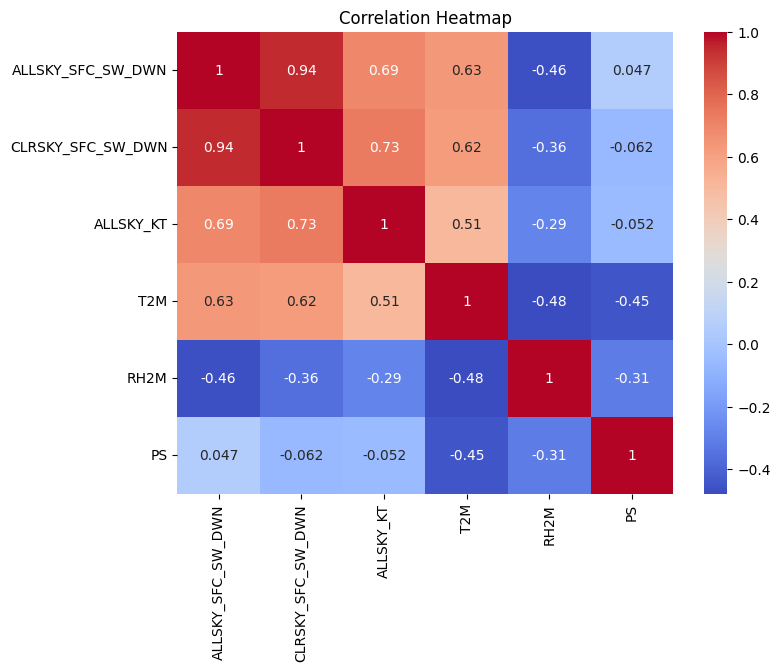

In [21]:
# Compute correlation on key numeric columns
corr = df[['ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'RH2M', 'PS']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


### Step 8: Line Plots for Trends

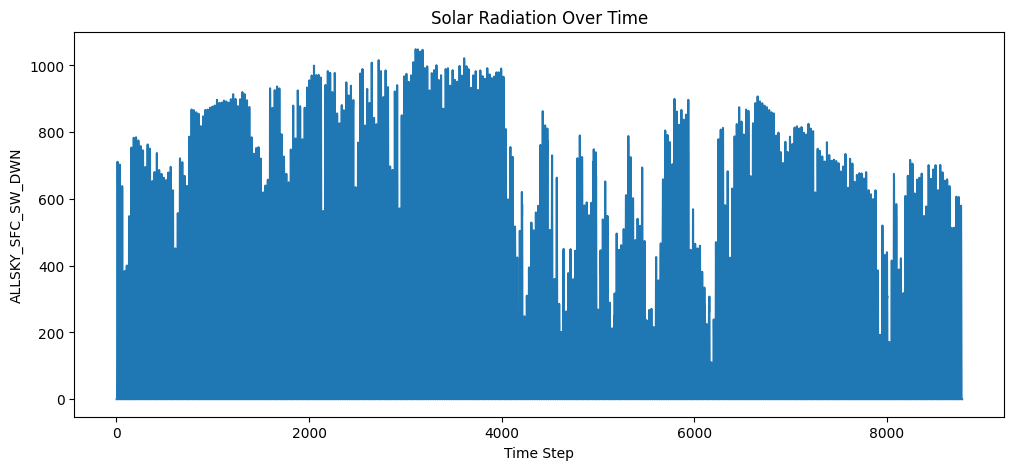

In [22]:
# Plot solar radiation over time
plt.figure(figsize=(12,5))
plt.plot(df['ALLSKY_SFC_SW_DWN'])
plt.title('Solar Radiation Over Time')
plt.xlabel('Time Step')
plt.ylabel('ALLSKY_SFC_SW_DWN')
plt.show()


### Step 9: Pairplot

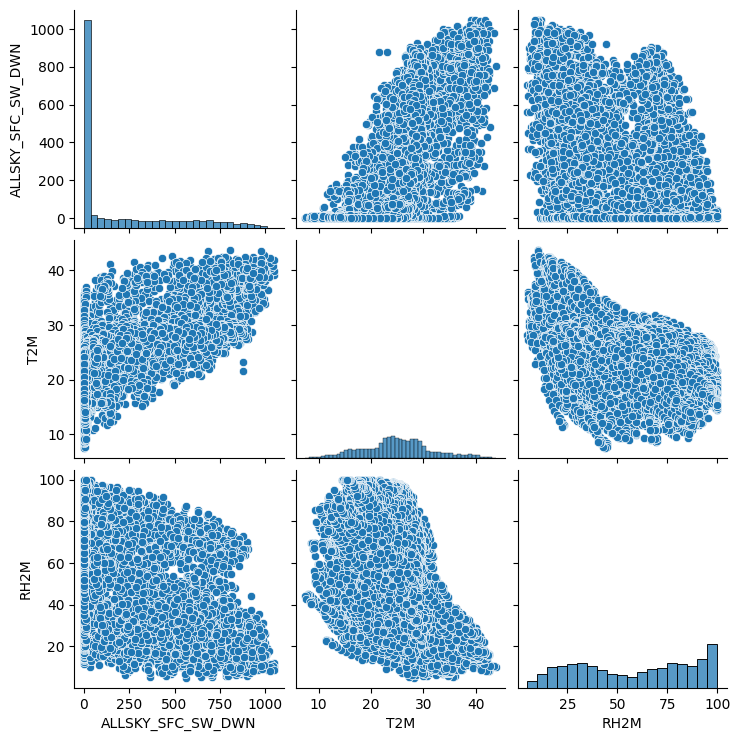

In [23]:
sns.pairplot(df[['ALLSKY_SFC_SW_DWN', 'T2M', 'RH2M']])
plt.show()

### Step 10: Outlier Check with Boxplots

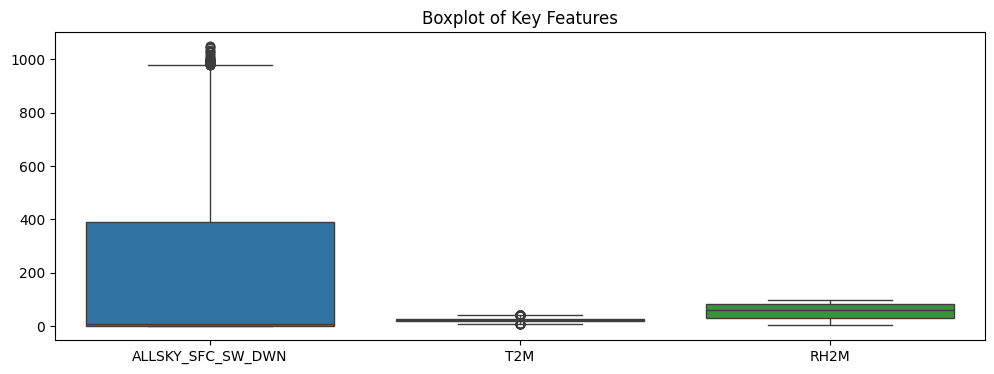

In [24]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df[['ALLSKY_SFC_SW_DWN', 'T2M', 'RH2M']])
plt.title('Boxplot of Key Features')
plt.show()


###  Step 12: Define X & y

In [25]:
features = ['ALLSKY_SFC_SW_DWN_lag1', 'ALLSKY_SFC_SW_DWN_lag2', 'T2M', 'RH2M']
target = 'ALLSKY_SFC_SW_DWN'

X = df[features]
y = df[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (8782, 4)
y shape: (8782,)


### Step 13: Train/Test Split

In [26]:
#  Step 13: Train/Test Split

split_idx = int(len(df) * 0.7)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f" X_train: {X_train.shape}")
print(f" X_test: {X_test.shape}")
print(f" y_train: {y_train.shape}")
print(f" y_test: {y_test.shape}")


 X_train: (6147, 4)
 X_test: (2635, 4)
 y_train: (6147,)
 y_test: (2635,)


###  Step 14: Scale Features

In [27]:
#  Step 14: Feature Scaling

from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

# Fit on training, transform training & test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')

print(" Features scaled and scaler saved.")


 Features scaled and scaler saved.


### Step 15: Train Random Forest

In [28]:
#  Step 15: Train Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Save trained model
joblib.dump(rf, 'rf_model.pkl')

print(" Random Forest model trained and saved.")


 Random Forest model trained and saved.


### Step 16: Evaluate Model

In [29]:
#  Step 16: Evaluate Model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = rf.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f' RMSE: {rmse:.2f}')
print(f' MAE: {mae:.2f}')
print(f' R²: {r2:.2f}')


 RMSE: 31.04
 MAE: 17.10
 R²: 0.99


### Step 17: Visualize Predictions

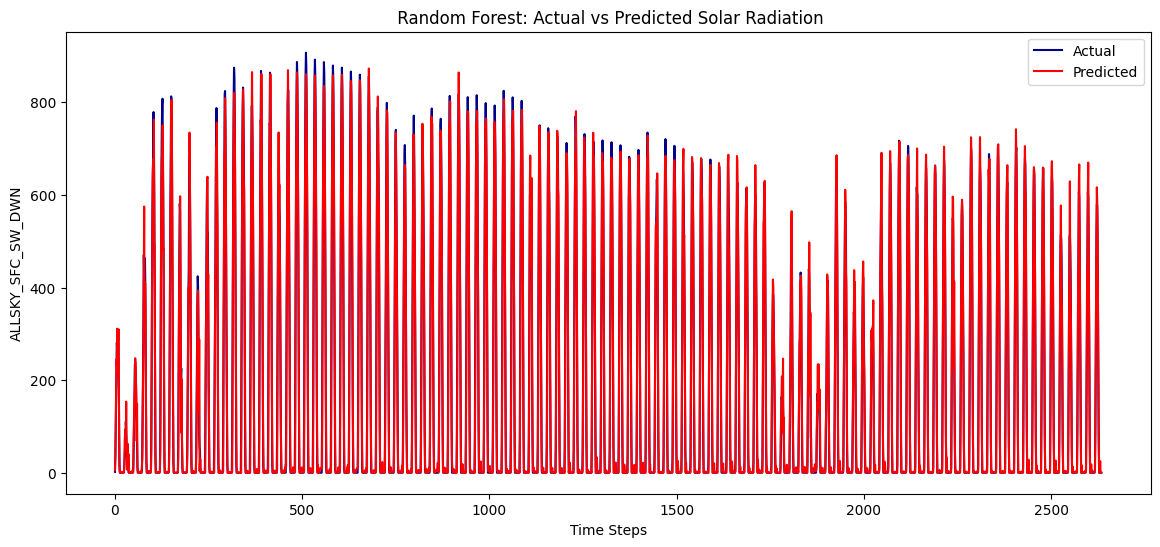

In [30]:
#  Step 17: Visualize Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual', color='darkblue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title(' Random Forest: Actual vs Predicted Solar Radiation')
plt.xlabel('Time Steps')
plt.ylabel('ALLSKY_SFC_SW_DWN')
plt.legend()
plt.show()


### Step 18: Feature Importance
#After training, Random Forest can tell you how important each feature is for making predictions.

                  Feature  Importance
0  ALLSKY_SFC_SW_DWN_lag1    0.919251
1  ALLSKY_SFC_SW_DWN_lag2    0.069287
3                    RH2M    0.008239
2                     T2M    0.003223


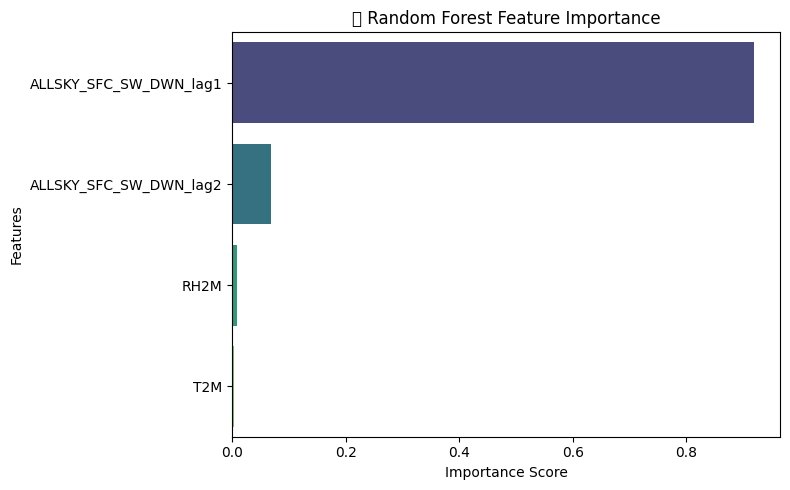

In [31]:
# ✅ Step 18: Feature Importance

import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the trained RF model
importances = rf.feature_importances_

# Pair each feature name with its importance score
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance values for reference
print(feature_importance)

# Plot as a barplot for easy visualization
plt.figure(figsize=(8,5))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('✅ Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


### Step 19: Charging Recommendation Logic
#### Uses predicted solar radiation to make a simple EV charging recommendation.

In [32]:
#  Step 19: Charging Recommendation

threshold = df['ALLSKY_SFC_SW_DWN'].max() * 0.7  # 70% of max radiation

recommendations = y_pred > threshold

print(" Charging recommended for:", sum(recommendations), "hours in test set")


 Charging recommended for: 100 hours in test set


### After training the model rf

In [33]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
import joblib

# Save the trained model
joblib.dump(rf, 'rf_model.pkl')
print(" Model saved as 'rf_model.pkl'")


 Model saved as 'rf_model.pkl'


In [35]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print(" Scaler saved as 'scaler.pkl'")


 Scaler saved as 'scaler.pkl'


In [36]:
# Load model and scaler
rf_loaded = joblib.load('rf_model.pkl')
scaler_loaded = joblib.load('scaler.pkl')

print(" Model and scaler loaded successfully!")

# Example: Make a prediction
# X_new_scaled = scaler_loaded.transform(X_new)
# y_pred = rf_loaded.predict(X_new_scaled)


 Model and scaler loaded successfully!
